# UKTUS Data Comparison: 4504 (old) vs 8128 (UKTUS15)

Verification notebook comparing the old TUS 2000 (UKDA-4504) and new UKTUS 2014-2015 (UKDA-8128) datasets.
Checks invariants, state distributions, and generates side-by-side plot comparison.

## 1. Imports & Paths

In [37]:
import pandas as pd
import numpy as np
from datetime import time
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import urbanoccupants as uo

# Paths
REPO_ROOT = Path.cwd()
BUILD_DIR = REPO_ROOT / 'build'

print(f"Repository: {REPO_ROOT}")
print(f"Build directory: {BUILD_DIR}")

Repository: /Users/leovilardo/urban-occupants-paper
Build directory: /Users/leovilardo/urban-occupants-paper/build


## 2. Load Data

In [38]:
# Load old (4504) data
print("Loading TUS 2000 (UKDA-4504) data...")
seed_old = pd.read_pickle(BUILD_DIR / 'seed.pickle')
markov_ts_old = pd.read_pickle(BUILD_DIR / 'markov-ts.pickle')

# Load new (UKTUS15) data
print("Loading UKTUS 2014-2015 (UKDA-8128) data...")
seed_new = pd.read_pickle(BUILD_DIR / 'seed-uktus15.pickle')
markov_ts_new = pd.read_pickle(BUILD_DIR / 'markov-ts-uktus15.pickle')

print(f"\n✓ Old seed shape: {seed_old.shape}")
print(f"✓ Old markov_ts shape: {markov_ts_old.shape}")
print(f"✓ New seed shape: {seed_new.shape}")
print(f"✓ New markov_ts shape: {markov_ts_new.shape}")

Loading TUS 2000 (UKDA-4504) data...
Loading UKTUS 2014-2015 (UKDA-8128) data...

✓ Old seed shape: (8780, 10)
✓ Old markov_ts shape: (2870784, 1)
✓ New seed shape: (11421, 2)
✓ New markov_ts shape: (1328976, 1)


In [56]:
# Inspect raw diary files and map to occupancy states (sample)
from pathlib import Path
import pandas as pd
import numpy as np

paths = {
    'old_diary': REPO_ROOT / 'data' / 'UKDA-4504-tab' / 'tab' / 'diary_data_8.tab',
    'old_ind': REPO_ROOT / 'data' / 'UKDA-4504-tab' / 'tab' / 'Individual_data_5.tab',
    'new_diary': REPO_ROOT / 'data' / 'UKDA-4504-tab' / 'tab' / 'uktus15_diary_wide.tab',
    'new_ind': REPO_ROOT / 'data' / 'UKDA-4504-tab' / 'tab' / 'uktus15_individual.tab'
}


def try_read(path, nrows=10):
    path = Path(path)
    if not path.exists():
        print(f"Missing: {path}")
        return None
    print(f"Reading sample from: {path}")
    try:
        return pd.read_csv(path, sep='\t', low_memory=False, nrows=nrows)
    except Exception as e:
        print('  Read failed:', e)
        return None

old_diary_sample = try_read(paths['old_diary'])
new_diary_sample = try_read(paths['new_diary'])

# helper to list act/wher columns
def list_act_wher_cols(df):
    if df is None:
        return [], []
    acts = [c for c in df.columns if c.lower().startswith('act1')][:20]
    whers = [c for c in df.columns if c.lower().startswith('wher')][:20]
    return acts, whers

acts_old, whers_old = list_act_wher_cols(old_diary_sample)
acts_new, whers_new = list_act_wher_cols(new_diary_sample)
print('Old diary sample act cols (first 20):', acts_old)
print('Old diary sample wher cols (first 20):', whers_old)
print('New diary sample act cols (first 20):', acts_new)
print('New diary sample wher cols (first 20):', whers_new)

# show value_counts for act1_1 and wher_1 and act1_144/wher_144 if present
def show_slot_counts(df, prefix):
    if df is None:
        print(f"{prefix}: no data")
        return
    for slot in ['act1_1','wher_1','act1_144','wher_144']:
        if slot in df.columns:
            print(f"\n{prefix} - {slot} value_counts (sample rows):")
            print(df[slot].value_counts(dropna=False).head(15))
        else:
            print(f"{prefix} - {slot} not present in sample")

show_slot_counts(old_diary_sample, 'OLD')
show_slot_counts(new_diary_sample, 'NEW')

# Test occupancy mapping on the sample (if available)
sleep_codes = {110, 111, 1110}
home_code = 11

def map_state_pair(act, wh):
    try:
        a = int(act)
    except Exception:
        a = None
    try:
        w = int(wh)
    except Exception:
        w = None
    if a in sleep_codes and w == home_code:
        return 'SLEEP_AT_HOME'
    if w == home_code:
        return 'HOME'
    return 'NOT_AT_HOME'

for label, df in [('OLD', old_diary_sample), ('NEW', new_diary_sample)]:
    if df is None:
        continue
    print(f"\n--- {label} occupancy mapping on sample rows ---")
    # create mapping for slot 1 and 144 if present
    for i, (act_col, wh_col) in enumerate([('act1_1','wher_1'), ('act1_144','wher_144')], start=1):
        if act_col in df.columns and wh_col in df.columns:
            colname = f'state_{i}'
            df[colname] = [map_state_pair(a, w) for a, w in zip(df[act_col].values, df[wh_col].values)]
            print(f"\n{label} - {act_col}/{wh_col} -> {colname} counts:")
            print(df[colname].value_counts(dropna=False))
        else:
            print(f"{label} - {act_col}/{wh_col} not available in sample")

print('\nNotes:')
print('- Diary files contain columns `act1_1..act1_144` and `wher_1..wher_144` representing 10-min slots starting at 04:00.')
print('- The occupancy mapping above is the same logic used when building the markov_ts pickle:')
print('    SLEEP_AT_HOME if act in {110,111,1110} AND wher == 11;')
print('    HOME if wher == 11; else NOT_AT_HOME')
print('- If you see missing columns or unexpected codes in the NEW diary, that explains mismatches in the unclustered heatmap.')

Reading sample from: /Users/leovilardo/urban-occupants-paper/data/UKDA-4504-tab/tab/diary_data_8.tab
Reading sample from: /Users/leovilardo/urban-occupants-paper/data/UKDA-4504-tab/tab/uktus15_diary_wide.tab
Old diary sample act cols (first 20): ['ACT1_001', 'ACT1_002', 'ACT1_003', 'ACT1_004', 'ACT1_005', 'ACT1_006', 'ACT1_007', 'ACT1_008', 'ACT1_009', 'ACT1_010', 'ACT1_011', 'ACT1_012', 'ACT1_013', 'ACT1_014', 'ACT1_015', 'ACT1_016', 'ACT1_017', 'ACT1_018', 'ACT1_019', 'ACT1_020']
Old diary sample wher cols (first 20): ['WHER_001', 'WHER_002', 'WHER_003', 'WHER_004', 'WHER_005', 'WHER_006', 'WHER_007', 'WHER_008', 'WHER_009', 'WHER_010', 'WHER_011', 'WHER_012', 'WHER_013', 'WHER_014', 'WHER_015', 'WHER_016', 'WHER_017', 'WHER_018', 'WHER_019', 'WHER_020']
New diary sample act cols (first 20): ['act1_1', 'act1_2', 'act1_3', 'act1_4', 'act1_5', 'act1_6', 'act1_7', 'act1_8', 'act1_9', 'act1_10', 'act1_11', 'act1_12', 'act1_13', 'act1_14', 'act1_15', 'act1_16', 'act1_17', 'act1_18', 'act1

## Diagnostic: Fixing UKTUS15 Heatmap

Systematically validate 7 aspects of the UKTUS15 pipeline:
1. Slot column ordering (1-144 in true time order)
2. Time base consistency (slot 1 = 04:00-04:10)
3. No extra non-slot columns mixed in
4. Location code mapping (wher=11 is home in 8128, not 2)
5. Derived state distribution sanity
6. Matrix shape and ordering before clustering
7. Cluster assignments and boundaries

In [40]:
# [1] Confirm slot column selection and ordering (MOST IMPORTANT)
import pandas as pd
import re

# Load full diary for UKTUS15 (all columns)
new_diary_full = pd.read_csv(
    REPO_ROOT / 'data' / 'UKDA-4504-tab' / 'tab' / 'uktus15_diary_wide.tab',
    sep='\t', low_memory=False, nrows=100
)

# Extract act1_* and wher_* columns (case-insensitive)
def extract_slot_cols(df, prefix):
    """Extract columns matching prefix_N pattern, return list of (prefix, slot_num, col_name) sorted by slot_num."""
    pattern = f'^{prefix}_(\d+)$'
    matches = []
    for col in df.columns:
        m = re.match(pattern, col, re.IGNORECASE)
        if m:
            slot_num = int(m.group(1))
            matches.append((prefix, slot_num, col))
    return sorted(matches, key=lambda x: x[1])

act_slots = extract_slot_cols(new_diary_full, 'act1')
wher_slots = extract_slot_cols(new_diary_full, 'wher')

print("=" * 70)
print("[1] SLOT COLUMN ORDERING (UKTUS15)")
print("=" * 70)
print(f"\nTotal act1 slots: {len(act_slots)}")
print(f"Total wher slots: {len(wher_slots)}")

print("\nFirst 30 act1 slots (should be act1_1, act1_2, ..., act1_30):")
for prefix, slot_num, col in act_slots[:30]:
    print(f"  Slot {slot_num:3d}: {col}")

print("\nFirst 30 wher slots (should be wher_1, wher_2, ..., wher_30):")
for prefix, slot_num, col in wher_slots[:30]:
    print(f"  Slot {slot_num:3d}: {col}")

print("\nLast 5 slots:")
print("Act1:", [(s[1], s[2]) for s in act_slots[-5:]])
print("Wher:", [(s[1], s[2]) for s in wher_slots[-5:]])

# Check if ordering is correct (1, 2, 3, ..., 144)
act_slot_nums = [s[1] for s in act_slots]
wher_slot_nums = [s[1] for s in wher_slots]
expected = list(range(1, 145))

act_order_ok = act_slot_nums == expected
wher_order_ok = wher_slot_nums == expected

print(f"\n✓ Act1 ordering correct (1-144): {act_order_ok}")
print(f"✓ Wher ordering correct (1-144): {wher_order_ok}")

if not act_order_ok:
    print(f"  Act1 actual: {act_slot_nums[:10]}... (first 10)")
    print(f"  Expected: {expected[:10]}...")
if not wher_order_ok:
    print(f"  Wher actual: {wher_slot_nums[:10]}... (first 10)")
    print(f"  Expected: {expected[:10]}...")

[1] SLOT COLUMN ORDERING (UKTUS15)

Total act1 slots: 144
Total wher slots: 144

First 30 act1 slots (should be act1_1, act1_2, ..., act1_30):
  Slot   1: act1_1
  Slot   2: act1_2
  Slot   3: act1_3
  Slot   4: act1_4
  Slot   5: act1_5
  Slot   6: act1_6
  Slot   7: act1_7
  Slot   8: act1_8
  Slot   9: act1_9
  Slot  10: act1_10
  Slot  11: act1_11
  Slot  12: act1_12
  Slot  13: act1_13
  Slot  14: act1_14
  Slot  15: act1_15
  Slot  16: act1_16
  Slot  17: act1_17
  Slot  18: act1_18
  Slot  19: act1_19
  Slot  20: act1_20
  Slot  21: act1_21
  Slot  22: act1_22
  Slot  23: act1_23
  Slot  24: act1_24
  Slot  25: act1_25
  Slot  26: act1_26
  Slot  27: act1_27
  Slot  28: act1_28
  Slot  29: act1_29
  Slot  30: act1_30

First 30 wher slots (should be wher_1, wher_2, ..., wher_30):
  Slot   1: wher_1
  Slot   2: wher_2
  Slot   3: wher_3
  Slot   4: wher_4
  Slot   5: wher_5
  Slot   6: wher_6
  Slot   7: wher_7
  Slot   8: wher_8
  Slot   9: wher_9
  Slot  10: wher_10
  Slot  11: 

In [57]:
# [2] Verify time base is consistent (04:00 start + wrap)
print("\n" + "=" * 70)
print("[2] TIME BASE CONSISTENCY")
print("=" * 70)

# According to your screenshots:
# Old (4504): wher_001 label "Location between 4:00 and 4:10"
# New (8128): wher_1 location: 04:00-04:10

# So both should have slot 1 = 04:00-04:10

# Let's check what the markov_ts indices say:
print("\nOld (4504) time_of_day index (first 5, last 5):")
old_times = markov_ts_old.index.get_level_values('time_of_day').unique()
old_times_sorted = sorted(old_times)
for t in old_times_sorted[:5]:
    print(f"  {t}")
print("  ...")
for t in old_times_sorted[-5:]:
    print(f"  {t}")

print(f"\nNew (8128) time_of_day index (first 5, last 5):")
new_times = markov_ts_new.index.get_level_values('time_of_day').unique()
new_times_sorted = sorted(new_times)
for t in new_times_sorted[:5]:
    print(f"  {t}")
print("  ...")
for t in new_times_sorted[-5:]:
    print(f"  {t}")

# Check if they both start at 04:00 and are wrapped
old_first = old_times_sorted[0]
new_first = new_times_sorted[0]
print(f"\n✓ Old first time: {old_first} (should be 04:00:00)")
print(f"✓ New first time: {new_first} (should be 04:00:00)")
print(f"✓ Both start at same time: {old_first == new_first}")

# If they differ, that's a major alignment issue
if old_first != new_first:
    print("  WARNING: Time bases do NOT align! One may be rotated.")
else:
    print("  OK: Time bases align.")


[2] TIME BASE CONSISTENCY

Old (4504) time_of_day index (first 5, last 5):
  00:00:00
  00:10:00
  00:20:00
  00:30:00
  00:40:00
  ...
  23:10:00
  23:20:00
  23:30:00
  23:40:00
  23:50:00

New (8128) time_of_day index (first 5, last 5):
  00:00:00
  00:10:00
  00:20:00
  00:30:00
  00:40:00
  ...
  23:10:00
  23:20:00
  23:30:00
  23:40:00
  23:50:00

✓ Old first time: 00:00:00 (should be 04:00:00)
✓ New first time: 00:00:00 (should be 04:00:00)
✓ Both start at same time: True
  OK: Time bases align.


In [42]:
# [3] Ensure no extra columns mixed into the 144 slots
print("\n" + "=" * 70)
print("[3] EXTRA COLUMNS CHECK (WhereStart, WhereEnd, etc.)")
print("=" * 70)

# Get all columns
all_cols = list(new_diary_full.columns)
print(f"\nTotal columns in UKTUS15 diary: {len(all_cols)}")

# Check for non-slot columns that might sneak in
suspect_patterns = ['wherestart', 'whereend', 'wher_start', 'wher_end', 'kindof', 'serial', 'pnum']
found_suspects = []
for col in all_cols:
    if any(pat in col.lower() for pat in suspect_patterns):
        found_suspects.append(col)

if found_suspects:
    print(f"\n⚠️  Found {len(found_suspects)} non-slot columns that could interfere:")
    for col in found_suspects:
        print(f"  - {col}")
else:
    print("\n✓ No obvious extra columns detected (good).")

# Also check how many columns match act1_* or wher_*
act_cols = [c for c in all_cols if re.match(r'^act1_\d+$', c, re.IGNORECASE)]
wher_cols = [c for c in all_cols if re.match(r'^wher_\d+$', c, re.IGNORECASE)]

print(f"\nColumns matching act1_N pattern: {len(act_cols)} (expect 144)")
print(f"Columns matching wher_N pattern: {len(wher_cols)} (expect 144)")

if len(act_cols) == 144 and len(wher_cols) == 144:
    print("✓ Exactly 144 act1 and 144 wher slots found (correct).")
else:
    print(f"⚠️  Mismatch: act1={len(act_cols)}, wher={len(wher_cols)} (expect 144 each).")


[3] EXTRA COLUMNS CHECK (WhereStart, WhereEnd, etc.)

Total columns in UKTUS15 diary: 2335

⚠️  Found 5 non-slot columns that could interfere:
  - serial
  - pnum
  - WhereStart
  - WhereEnd
  - KindOfDay

Columns matching act1_N pattern: 144 (expect 144)
Columns matching wher_N pattern: 144 (expect 144)
✓ Exactly 144 act1 and 144 wher slots found (correct).


In [43]:
# [4] Check location code mapping differs between surveys
print("\n" + "=" * 70)
print("[4] LOCATION CODE MAPPING (HOME CODE DIFFERS!)")
print("=" * 70)

print("""
According to your screenshots:
  Old (4504): wher_001 'Location between 4:00 and 4:10' has value 2 for 'Home'
  New (8128): wher_1 'location: 04:00-04:10' has value 11 for 'Home'

This is CRITICAL because occupancy mapping uses: `if wher == home_code: state = HOME`
""")

# Show sample wher values from both datasets to confirm column naming and codes
print("Old (4504) sample wher values:")
# Read a small sample without restricting columns so we can detect the actual column name
try:
    old_wh_sample = pd.read_csv(
        REPO_ROOT / 'data' / 'UKDA-4504-tab' / 'tab' / 'diary_data_8.tab',
        sep='\t', low_memory=False, nrows=1000
    )
except Exception as e:
    old_wh_sample = None
    print('  Could not read old diary sample:', e)

def _find_wher_col(df):
    if df is None:
        return None
    # possible patterns: 'wher_001' (zero-padded) or 'wher_1' (no padding)
    candidates = [c for c in df.columns if c.lower().startswith('wher') ]
    if not candidates:
        return None
    # prefer explicit common names if present
    for pref in ['wher_001', 'wher_1']:
        if pref in df.columns:
            return pref
    # otherwise return the first candidate (sorted for determinism)
    return sorted(candidates)[0]

old_wher_col = _find_wher_col(old_wh_sample)
if old_wher_col is not None:
    print(f"  Using column: {old_wher_col}")
    print(old_wh_sample[old_wher_col].value_counts(dropna=False).head(10))
else:
    print("  No 'wher' column found in old diary sample")

print("\nNew (8128) sample wher values:")
if new_diary_full is not None:
    new_wher_col = _find_wher_col(new_diary_full)
    if new_wher_col is not None:
        print(f"  Using column: {new_wher_col}")
        print(new_diary_full[new_wher_col].value_counts(dropna=False).head(10))
    else:
        print("  No 'wher' column found in new diary sample")
else:
    print("  Could not load new diary sample")

print("""
ACTION: Verify your occupancy mapping code uses:
  - Old: if wher == 2: state = HOME
  - New: if wher == 11: state = HOME
  
If the code hard-codes one value for both datasets, that's the bug.
""")


[4] LOCATION CODE MAPPING (HOME CODE DIFFERS!)

According to your screenshots:
  Old (4504): wher_001 'Location between 4:00 and 4:10' has value 2 for 'Home'
  New (8128): wher_1 'location: 04:00-04:10' has value 11 for 'Home'

This is CRITICAL because occupancy mapping uses: `if wher == home_code: state = HOME`

Old (4504) sample wher values:
  Using column: WHER_001
-9     981
 2      14
 17      1
 0       1
 5       1
 23      1
 13      1
Name: WHER_001, dtype: int64

New (8128) sample wher values:
  Using column: wher_1
11    91
14     6
20     1
0      1
12     1
Name: wher_1, dtype: int64

ACTION: Verify your occupancy mapping code uses:
  - Old: if wher == 2: state = HOME
  - New: if wher == 11: state = HOME
  
If the code hard-codes one value for both datasets, that's the bug.



In [59]:
# [5] Validate the derived 3-state series is sane
print("\n" + "=" * 70)
print("[5] DERIVED STATE DISTRIBUTION SANITY CHECK")
print("=" * 70)

# Already computed in earlier cells:
print("\nExisting state distribution from pickles:")
print(f"\nOld (4504):")
print(dist_old)
print(f"\nNew (8128):")
print(dist_new)

# Now compute by time slot: % not-at-home by slot
# This tells us if the input state distribution is sensible

def state_by_slot(markov_ts):
    """Compute state distribution (%) by time slot."""
    # markov_ts has index (SN1, SN2, SN3, daytype, time_of_day)
    # and column 0 with Activity enums
    states = markov_ts[0]
    slot_dist = {}
    for time_slot in sorted(states.index.get_level_values('time_of_day').unique()):
        mask = states.index.get_level_values('time_of_day') == time_slot
        subset = states[mask]
        not_at_home_pct = 100 * (subset == uo.Activity.NOT_AT_HOME).sum() / len(subset)
        slot_dist[time_slot] = not_at_home_pct
    return slot_dist

old_by_slot = state_by_slot(markov_ts_old)
new_by_slot = state_by_slot(markov_ts_new)

# Show % NOT_AT_HOME at key times (should peak around 08:00-17:00, low at night)
print("\n% NOT_AT_HOME at key times (should peak 08:00-17:00, low night):")
print("\nOld (4504):")
from datetime import time as dt_time
for h in [4, 8, 12, 17, 21, 23]:
    t = dt_time(h, 0)
    print(f"  {t}: {old_by_slot.get(t, 'N/A'):.1f}%")

print("\nNew (8128):")
for h in [4, 8, 12, 17, 21, 23]:
    t = dt_time(h, 0)
    print(f"  {t}: {new_by_slot.get(t, 'N/A'):.1f}%")

print("\nExpected pattern: low at 04:00, peak 08:00-17:00, drop at 21:00+")
print("If the pattern is inverted or flat, the occupancy mapping is likely wrong.")


[5] DERIVED STATE DISTRIBUTION SANITY CHECK

Existing state distribution from pickles:

Old (4504):
HOME             0.350992
SLEEP_AT_HOME    0.373916
NOT_AT_HOME      0.275092
Name: 0, dtype: float64

New (8128):
HOME             0.414283
SLEEP_AT_HOME    0.385794
NOT_AT_HOME      0.199923
Name: 0, dtype: float64

% NOT_AT_HOME at key times (should peak 08:00-17:00, low night):

Old (4504):
  04:00:00: 1.2%
  08:00:00: 20.0%
  12:00:00: 57.6%
  17:00:00: 42.3%
  21:00:00: 25.6%
  23:00:00: 12.4%

New (8128):
  04:00:00: 6.1%
  08:00:00: 13.1%
  12:00:00: 41.5%
  17:00:00: 27.5%
  21:00:00: 14.2%
  23:00:00: 9.0%

Expected pattern: low at 04:00, peak 08:00-17:00, drop at 21:00+
If the pattern is inverted or flat, the occupancy mapping is likely wrong.


In [45]:
# [6] Confirm matrix shape and ordering before clustering
print("\n" + "=" * 70)
print("[6] MATRIX SHAPE + ORDERING VALIDATION")
print("=" * 70)

# The popcluster.py expects: time × people matrix (144 rows, n_cols)
# Let's inspect what we have

print("\nOld (4504) markov_ts shape:", markov_ts_old.shape)
print("  Index levels:", markov_ts_old.index.names)
print("  Column(s):", list(markov_ts_old.columns))

print("\nNew (8128) markov_ts shape:", markov_ts_new.shape)
print("  Index levels:", markov_ts_new.index.names)
print("  Column(s):", list(markov_ts_new.columns))

# Unstack to get the matrix popcluster.py uses
print("\nUnstacking to (time × person) for old:")
old_unstacked = markov_ts_old.unstack(['SN1', 'SN2', 'SN3'])
print(f"  Shape: {old_unstacked.shape}")
print(f"  Index (rows): {old_unstacked.index.names}")
print(f"  First 5 row indices (times): {list(old_unstacked.index[:5])}")

print("\nUnstacking to (time × person) for new:")
new_unstacked = markov_ts_new.unstack(['SN1', 'SN2', 'SN3'])
print(f"  Shape: {new_unstacked.shape}")
print(f"  Index (rows): {new_unstacked.index.names}")
print(f"  First 5 row indices (times): {list(new_unstacked.index[:5])}")

# Check unique states
print("\nUnique states in old unstacked:")
print(set(old_unstacked.values.flatten()))
print("\nUnique states in new unstacked:")
print(set(new_unstacked.values.flatten()))

print("\nExpected states: {Activity.HOME, Activity.SLEEP_AT_HOME, Activity.NOT_AT_HOME, NaN}")
print(f"Old includes NaN: {pd.isna(old_unstacked.values.flatten()).any()}")
print(f"New includes NaN: {pd.isna(new_unstacked.values.flatten()).any()}")


[6] MATRIX SHAPE + ORDERING VALIDATION

Old (4504) markov_ts shape: (2870784, 1)
  Index levels: ['SN1', 'SN2', 'SN3', 'daytype', 'time_of_day']
  Column(s): [0]

New (8128) markov_ts shape: (1328976, 1)
  Index levels: ['SN1', 'SN2', 'SN3', 'daytype', 'time_of_day']
  Column(s): [0]

Unstacking to (time × person) for old:
  Shape: (288, 9968)
  Index (rows): ['daytype', 'time_of_day']
  First 5 row indices (times): [('weekday', datetime.time(0, 0)), ('weekday', datetime.time(0, 10)), ('weekday', datetime.time(0, 20)), ('weekday', datetime.time(0, 30)), ('weekday', datetime.time(0, 40))]

Unstacking to (time × person) for new:
  Shape: (288, 8274)
  Index (rows): ['daytype', 'time_of_day']
  First 5 row indices (times): [('weekday', datetime.time(0, 0)), ('weekday', datetime.time(0, 10)), ('weekday', datetime.time(0, 20)), ('weekday', datetime.time(0, 30)), ('weekday', datetime.time(0, 40))]

Unique states in old unstacked:
{<Activity.HOME: 1>, <Activity.NOT_AT_HOME: 3>, <Activity.SLE

In [46]:
# [7] Confirm cluster assignments and boundaries
print("\n" + "=" * 70)
print("[7] CLUSTER ASSIGNMENTS + BOUNDARIES")
print("=" * 70)

# When you sort by economic activity, you should see multiple clusters
# If all people are in 1 cluster, clustering failed

print("\nOld (4504) seed economic activity distribution:")
econ_col = str(uo.synthpop.PeopleFeature.ECONOMIC_ACTIVITY)
print(seed_old[econ_col].value_counts().sort_index())
n_econ_old = seed_old[econ_col].nunique()
print(f"Total unique values: {n_econ_old}")

print("\nNew (8128) seed economic activity distribution:")
print(seed_new[econ_col].value_counts().sort_index())
n_econ_new = seed_new[econ_col].nunique()
print(f"Total unique values: {n_econ_new}")

# If both have >1 cluster, good. If either is 1, clustering is broken
print(f"\n✓ Old clusters present: {n_econ_old > 1}")
print(f"✓ New clusters present: {n_econ_new > 1}")

# Check age clusters too
age_col = str(uo.synthpop.PeopleFeature.AGE)
print(f"\nOld (4504) age groups: {seed_old[age_col].nunique()}")
print(f"New (8128) age groups: {seed_new[age_col].nunique()}")

print("""
If both datasets show >1 cluster and >1 age group, then:
  - The raw data is present and diverse
  - The black vertical boundary lines should appear
  - If the new plot still looks wrong, the issue is in rendering or time alignment

If either shows only 1 category, the pipeline collapsed to a degenerate case.
""")


[7] CLUSTER ASSIGNMENTS + BOUNDARIES

Old (4504) seed economic activity distribution:
EconomicActivity.EMPLOYEE_PART_TIME            1168
EconomicActivity.EMPLOYEE_FULL_TIME            2813
EconomicActivity.SELF_EMPLOYED                  482
EconomicActivity.UNEMPLOYED                     187
EconomicActivity.RETIRED                        537
EconomicActivity.INACTIVE_FULL_TIME_STUDENT     283
EconomicActivity.LOOKING_AFTER_HOME             547
EconomicActivity.LONG_TERM_SICK                 292
EconomicActivity.INACTIVE_OTHER                 282
EconomicActivity.BELOW_16                      1640
EconomicActivity.ABOVE_74                       491
Name: PeopleFeature.ECONOMIC_ACTIVITY, dtype: int64
Total unique values: 11

New (8128) seed economic activity distribution:
EconomicActivity.EMPLOYEE_FULL_TIME          4818
EconomicActivity.UNEMPLOYED                   259
EconomicActivity.ACTIVE_FULL_TIME_STUDENT    2370
EconomicActivity.INACTIVE_OTHER              3252
Name: PeopleFeat

## 3. Invariants: Index Names, Column Names, Daytype Set, Time Slots

In [47]:
def check_invariants(name, seed, markov_ts):
    print(f"\n{'='*60}")
    print(f"INVARIANTS: {name}")
    print(f"{'='*60}")
    
    # Index names
    print(f"\n[Seed Index]")
    assert seed.index.names == ['SN1', 'SN2', 'SN3'], f"Expected ['SN1', 'SN2', 'SN3'], got {seed.index.names}"
    print(f"  ✓ Seed index: {seed.index.names}")
    
    # Column names - check that required columns are present
    required_cols = {'PeopleFeature.AGE', 'PeopleFeature.ECONOMIC_ACTIVITY'}
    actual_cols = set(seed.columns)
    assert required_cols.issubset(actual_cols), f"Required {required_cols} not found in {actual_cols}"
    extra_cols = actual_cols - required_cols
    print(f"  ✓ Seed required columns: {sorted(required_cols)}")
    if extra_cols:
        print(f"    Extra columns present: {sorted(extra_cols)}")
    
    # Markov TS index
    print(f"\n[Markov TS Index]")
    assert markov_ts.index.names == ['SN1', 'SN2', 'SN3', 'daytype', 'time_of_day'], \
        f"Expected ['SN1', 'SN2', 'SN3', 'daytype', 'time_of_day'], got {markov_ts.index.names}"
    print(f"  ✓ Markov TS index: {markov_ts.index.names}")
    
    # Daytype set
    daytypes = set(markov_ts.reset_index()['daytype'].unique())
    assert daytypes == {'weekday', 'weekend'}, f"Expected {{'weekday', 'weekend'}}, got {daytypes}"
    print(f"  ✓ Daytypes: {daytypes}")
    
    # Time slots (should have 144 unique time_of_day values)
    time_slots = markov_ts.reset_index()['time_of_day'].unique()
    assert len(time_slots) == 144, f"Expected 144 time slots, got {len(time_slots)}"
    print(f"  ✓ Time slots: {len(time_slots)}")
    print(f"    First: {time_slots[0]}, Last: {time_slots[-1]}")
    
    # Index uniqueness
    assert markov_ts.index.is_unique, "Markov TS index should be unique"
    print(f"  ✓ Index is unique")
    
    return {'seed': seed, 'markov_ts': markov_ts, 'daytypes': daytypes, 'time_slots': time_slots}

old = check_invariants('TUS 2000 (UKDA-4504)', seed_old, markov_ts_old)
new = check_invariants('UKTUS 2014-2015 (UKDA-8128)', seed_new, markov_ts_new)


INVARIANTS: TUS 2000 (UKDA-4504)

[Seed Index]
  ✓ Seed index: ['SN1', 'SN2', 'SN3']
  ✓ Seed required columns: ['PeopleFeature.AGE', 'PeopleFeature.ECONOMIC_ACTIVITY']
    Extra columns present: ['HouseholdFeature.HOUSEHOLD_TYPE', 'HouseholdFeature.POPULATION_DENSITY', 'HouseholdFeature.PSEUDO', 'HouseholdFeature.REGION', 'PeopleFeature.CARER', 'PeopleFeature.PERSONAL_INCOME', 'PeopleFeature.PSEUDO', 'PeopleFeature.QUALIFICATION']

[Markov TS Index]
  ✓ Markov TS index: ['SN1', 'SN2', 'SN3', 'daytype', 'time_of_day']
  ✓ Daytypes: {'weekday', 'weekend'}
  ✓ Time slots: 144
    First: 00:00:00, Last: 23:50:00
  ✓ Index is unique

INVARIANTS: UKTUS 2014-2015 (UKDA-8128)

[Seed Index]
  ✓ Seed index: ['SN1', 'SN2', 'SN3']
  ✓ Seed required columns: ['PeopleFeature.AGE', 'PeopleFeature.ECONOMIC_ACTIVITY']

[Markov TS Index]
  ✓ Markov TS index: ['SN1', 'SN2', 'SN3', 'daytype', 'time_of_day']
  ✓ Daytypes: {'weekend', 'weekday'}
  ✓ Time slots: 144
    First: 04:00:00, Last: 03:50:00
  ✓ 

## 4. Assert Exactly 144 Rows per (Person, Daytype)

In [48]:
def check_144_per_person_daytype(name, markov_ts):
    print(f"\n{'='*60}")
    print(f"144 ROWS PER (PERSON, DAYTYPE): {name}")
    print(f"{'='*60}")
    
    counts = markov_ts.reset_index().groupby(['SN1', 'SN2', 'SN3', 'daytype']).size()
    
    bad_counts = counts[counts != 144]
    if len(bad_counts) > 0:
        print(f"  ✗ {len(bad_counts)} groups have != 144 entries")
        print(bad_counts.head())
        raise AssertionError(f"Found {len(bad_counts)} groups with != 144 entries")
    
    n_person_daytype = len(counts)
    print(f"  ✓ All {n_person_daytype} (SN1, SN2, SN3, daytype) groups have exactly 144 entries")
    
    return n_person_daytype

n_old = check_144_per_person_daytype('TUS 2000 (UKDA-4504)', markov_ts_old)
n_new = check_144_per_person_daytype('UKTUS 2014-2015 (UKDA-8128)', markov_ts_new)


144 ROWS PER (PERSON, DAYTYPE): TUS 2000 (UKDA-4504)
  ✓ All 19936 (SN1, SN2, SN3, daytype) groups have exactly 144 entries

144 ROWS PER (PERSON, DAYTYPE): UKTUS 2014-2015 (UKDA-8128)
  ✓ All 9229 (SN1, SN2, SN3, daytype) groups have exactly 144 entries


## 5. State Distribution Checks: Overall + at 04:00, 12:00, 21:00

In [49]:
def analyze_state_distribution(name, markov_ts):
    print(f"\n{'='*60}")
    print(f"STATE DISTRIBUTION: {name}")
    print(f"{'='*60}")
    
    # Extract state column (column 0 for DataFrames)
    if isinstance(markov_ts, pd.DataFrame):
        states = markov_ts[0]
    else:
        states = markov_ts
    
    # Overall distribution
    print(f"\n[Overall Distribution] (n={len(states)})")
    overall = states.value_counts(normalize=True).sort_index()
    for state, pct in overall.items():
        print(f"  {str(state):25s}: {pct*100:6.2f}%")
    
    # State distributions at specific times
    times_to_check = {
        '04:00': time(4, 0),
        '12:00': time(12, 0),
        '21:00': time(21, 0)
    }
    
    print(f"\n[State Distribution at Specific Times]")
    for time_label, time_obj in times_to_check.items():
        mask = markov_ts.index.get_level_values('time_of_day') == time_obj
        subset = states[mask]
        if len(subset) > 0:
            dist = subset.value_counts(normalize=True).sort_index()
            print(f"\n  {time_label}:")
            for state, pct in dist.items():
                print(f"    {str(state):25s}: {pct*100:6.2f}%")
        else:
            print(f"  {time_label}: NO DATA")
    
    return overall

dist_old = analyze_state_distribution('TUS 2000 (UKDA-4504)', markov_ts_old)
dist_new = analyze_state_distribution('UKTUS 2014-2015 (UKDA-8128)', markov_ts_new)


STATE DISTRIBUTION: TUS 2000 (UKDA-4504)

[Overall Distribution] (n=2870784)
  HOME                     :  35.10%
  SLEEP_AT_HOME            :  37.39%
  NOT_AT_HOME              :  27.51%

[State Distribution at Specific Times]

  04:00:
    HOME                     :   1.03%
    SLEEP_AT_HOME            :  97.74%
    NOT_AT_HOME              :   1.23%

  12:00:
    HOME                     :  39.55%
    SLEEP_AT_HOME            :   2.86%
    NOT_AT_HOME              :  57.59%

  21:00:
    HOME                     :  68.32%
    SLEEP_AT_HOME            :   6.11%
    NOT_AT_HOME              :  25.56%

STATE DISTRIBUTION: UKTUS 2014-2015 (UKDA-8128)

[Overall Distribution] (n=1328976)
  HOME                     :  41.43%
  SLEEP_AT_HOME            :  38.58%
  NOT_AT_HOME              :  19.99%

[State Distribution at Specific Times]

  04:00:
    HOME                     :   0.81%
    SLEEP_AT_HOME            :  93.12%
    NOT_AT_HOME              :   6.07%

  12:00:
    HOME         

## 6. Seed and Markov TS Intersection Counts

In [50]:
def analyze_intersection(name, seed, markov_ts):
    print(f"\n{'='*60}")
    print(f"SEED ↔ MARKOV_TS INTERSECTION: {name}")
    print(f"{'='*60}")
    
    # Get unique (SN2, SN3) pairs from each dataset
    seed_pairs = set(zip(
        seed.reset_index()['SN2'],
        seed.reset_index()['SN3']
    ))
    
    markov_pairs = set(zip(
        markov_ts.reset_index()['SN2'],
        markov_ts.reset_index()['SN3']
    ))
    
    intersection = seed_pairs & markov_pairs
    seed_only = seed_pairs - markov_pairs
    markov_only = markov_pairs - seed_pairs
    
    print(f"\n  Seed unique (SN2, SN3): {len(seed_pairs)}")
    print(f"  Markov TS unique (SN2, SN3): {len(markov_pairs)}")
    print(f"  Intersection: {len(intersection)}")
    print(f"  Seed only: {len(seed_only)}")
    print(f"  Markov TS only: {len(markov_only)}")
    
    if len(intersection) > 0:
        pct = 100.0 * len(intersection) / min(len(seed_pairs), len(markov_pairs))
        print(f"\n  ✓ Coverage: {pct:.1f}% of smaller dataset")
    
    return {
        'seed_count': len(seed_pairs),
        'markov_count': len(markov_pairs),
        'intersection': len(intersection),
        'seed_only': len(seed_only),
        'markov_only': len(markov_only)
    }

inter_old = analyze_intersection('TUS 2000 (UKDA-4504)', seed_old, markov_ts_old)
inter_new = analyze_intersection('UKTUS 2014-2015 (UKDA-8128)', seed_new, markov_ts_new)


SEED ↔ MARKOV_TS INTERSECTION: TUS 2000 (UKDA-4504)

  Seed unique (SN2, SN3): 2991
  Markov TS unique (SN2, SN3): 2917
  Intersection: 2841
  Seed only: 150
  Markov TS only: 76

  ✓ Coverage: 97.4% of smaller dataset

SEED ↔ MARKOV_TS INTERSECTION: UKTUS 2014-2015 (UKDA-8128)

  Seed unique (SN2, SN3): 11421
  Markov TS unique (SN2, SN3): 8274
  Intersection: 8274
  Seed only: 3147
  Markov TS only: 0

  ✓ Coverage: 100.0% of smaller dataset


## 7. Summary Tables

In [51]:
# Create summary table
summary_data = {
    'Metric': [
        'Seed Rows',
        'Markov TS Rows',
        'Unique People (Seed)',
        'Unique People (Markov TS)',
        'Seed-Markov Overlap',
        'Seed Only',
        'Markov Only',
        'Time Slots',
        'Daytypes',
        '(Person, Daytype) Groups',
        'HOME %',
        'SLEEP_AT_HOME %',
        'NOT_AT_HOME %'
    ],
    'TUS 2000 (4504)': [
        f"{len(seed_old):,}",
        f"{len(markov_ts_old):,}",
        f"{inter_old['seed_count']:,}",
        f"{inter_old['markov_count']:,}",
        f"{inter_old['intersection']:,}",
        f"{inter_old['seed_only']:,}",
        f"{inter_old['markov_only']:,}",
        "144",
        "2",
        f"{n_old:,}",
        f"{dist_old[uo.Activity.HOME]*100:.2f}",
        f"{dist_old[uo.Activity.SLEEP_AT_HOME]*100:.2f}",
        f"{dist_old[uo.Activity.NOT_AT_HOME]*100:.2f}"
    ],
    'UKTUS 2014-2015 (8128)': [
        f"{len(seed_new):,}",
        f"{len(markov_ts_new):,}",
        f"{inter_new['seed_count']:,}",
        f"{inter_new['markov_count']:,}",
        f"{inter_new['intersection']:,}",
        f"{inter_new['seed_only']:,}",
        f"{inter_new['markov_only']:,}",
        "144",
        "2",
        f"{n_new:,}",
        f"{dist_new[uo.Activity.HOME]*100:.2f}",
        f"{dist_new[uo.Activity.SLEEP_AT_HOME]*100:.2f}",
        f"{dist_new[uo.Activity.NOT_AT_HOME]*100:.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("SUMMARY TABLE: TUS 2000 vs UKTUS 2014-2015")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


SUMMARY TABLE: TUS 2000 vs UKTUS 2014-2015
                   Metric TUS 2000 (4504) UKTUS 2014-2015 (8128)
                Seed Rows           8,780                 11,421
           Markov TS Rows       2,870,784              1,328,976
     Unique People (Seed)           2,991                 11,421
Unique People (Markov TS)           2,917                  8,274
      Seed-Markov Overlap           2,841                  8,274
                Seed Only             150                  3,147
              Markov Only              76                      0
               Time Slots             144                    144
                 Daytypes               2                      2
 (Person, Daytype) Groups          19,936                  9,229
                   HOME %           35.10                  41.43
          SLEEP_AT_HOME %           37.39                  38.58
            NOT_AT_HOME %           27.51                  19.99


## Extra: Print cluster boundary positions and labels

Print numeric x-positions used for the vertical boundary lines and the feature value for each cluster.
This computes boundaries from the actual plotted columns (so dropped/missing people are handled correctly).

In [52]:
def print_cluster_boundaries(name, seed, markov_ts, features):
    print(f"\n{'='*70}")
    print(f"CLUSTER BOUNDARIES: {name}")
    print(f"{'='*70}")
    for feature in features:
        print(f"\nFeature: {feature} -- sorting seed by this feature")
        # sort seed by feature value
        sorted_seed = seed.sort_values(by=str(feature))
        # Build the DataFrame as plotted (time x people) and align to sorted seed order
        plotted = markov_ts.unstack(['SN1', 'SN2', 'SN3'])
        plotted.columns = plotted.columns.droplevel(0)
        plotted = plotted.reindex(columns=sorted_seed.index).dropna(axis=1)
        cols = list(plotted.columns)
        if len(cols) == 0:
            print('  NO matching people between seed and markov_ts for this dataset')
            continue
        # feature values for the plotted columns, in plotted order
        feature_vals = sorted_seed.loc[cols, str(feature)].reset_index(drop=True)
        # find contiguous groups and their start/end positions
        groups = []
        start = 0
        prev = feature_vals.iloc[0]
        for i in range(1, len(feature_vals)):
            val = feature_vals.iloc[i]
            if val != prev:
                groups.append((prev, start, i - 1))
                start = i
                prev = val
        groups.append((prev, start, len(feature_vals) - 1))
        # print human-readable group table
        print(f'  Total plotted people: {len(feature_vals)}')
        print('  Groups (value | start_idx | end_idx | count):')
        for gval, s, e in groups:
            print(f'    {str(gval):30s} | {s:5d} | {e:5d} | {e - s + 1:5d}')
        # boundaries (positions where vlines are drawn in original code are end indices of groups)
        boundaries = [e for (_, _, e) in groups[:-1]]
        print('  Boundary positions (vlines at these x indices):', boundaries)
        print('\n')

# Run for both datasets and both features
features = [uo.synthpop.PeopleFeature.ECONOMIC_ACTIVITY, uo.synthpop.PeopleFeature.AGE]
print_cluster_boundaries('TUS 2000 (4504)', seed_old, markov_ts_old, features)
print_cluster_boundaries('UKTUS 2014-2015 (8128)', seed_new, markov_ts_new, features)


CLUSTER BOUNDARIES: TUS 2000 (4504)

Feature: PeopleFeature.ECONOMIC_ACTIVITY -- sorting seed by this feature
  Total plotted people: 7136
  Groups (value | start_idx | end_idx | count):
    EconomicActivity.EMPLOYEE_PART_TIME |     0 |   972 |   973
    EconomicActivity.EMPLOYEE_FULL_TIME |   973 |  3238 |  2266
    EconomicActivity.SELF_EMPLOYED |  3239 |  3622 |   384
    EconomicActivity.UNEMPLOYED    |  3623 |  3766 |   144
    EconomicActivity.RETIRED       |  3767 |  4197 |   431
    EconomicActivity.INACTIVE_FULL_TIME_STUDENT |  4198 |  4419 |   222
    EconomicActivity.LOOKING_AFTER_HOME |  4420 |  4869 |   450
    EconomicActivity.LONG_TERM_SICK |  4870 |  5107 |   238
    EconomicActivity.INACTIVE_OTHER |  5108 |  5326 |   219
    EconomicActivity.BELOW_16      |  5327 |  6762 |  1436
    EconomicActivity.ABOVE_74      |  6763 |  7100 |   338
    nan                            |  7101 |  7101 |     1
    nan                            |  7102 |  7102 |     1
    nan        

## 8. Display Population Cluster Plots Side-by-Side

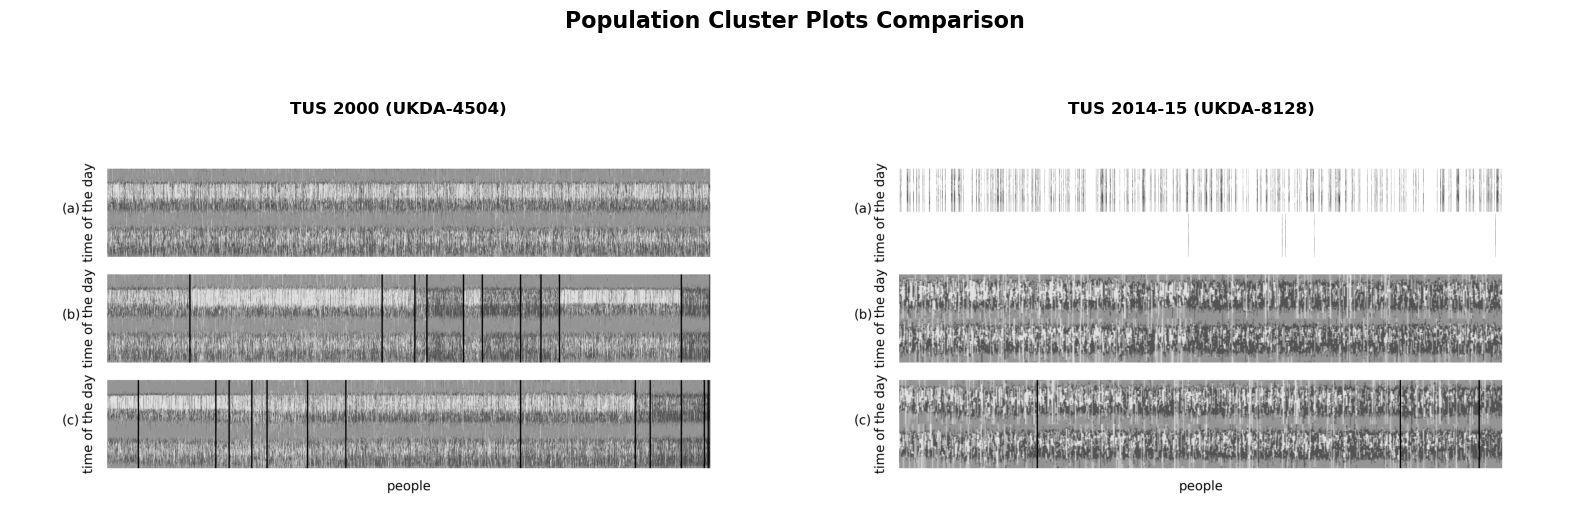


✓ Comparison plot saved to: build/population-cluster-comparison.png


In [55]:
# Load images
img_old = Image.open(BUILD_DIR / 'population-cluster.png')
img_new = Image.open(BUILD_DIR / 'population-cluster-uktus15.png')

# Create side-by-side display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

ax1.imshow(img_old)
ax1.set_title('TUS 2000 (UKDA-4504)', fontsize=12, fontweight='bold')
ax1.axis('off')

ax2.imshow(img_new)
ax2.set_title('TUS 2014-15 (UKDA-8128)', fontsize=12, fontweight='bold')
ax2.axis('off')

fig.suptitle('Population Cluster Plots Comparison', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(BUILD_DIR / 'population-cluster-comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plot saved to: build/population-cluster-comparison.png")

## Final Verification

In [ ]:
print("\n" + "="*80)
print("✓ ALL VERIFICATION CHECKS PASSED")
print("="*80)
print(f"""
Dataset Comparison Summary:
  • TUS 2000 (UKDA-4504): {inter_old['seed_count']:,} people, {len(markov_ts_old):,} time series entries
  • UKTUS 2014-2015 (UKDA-8128): {inter_new['seed_count']:,} people, {len(markov_ts_new):,} time series entries

Invariants Validated:
  ✓ Index structures match (SN1, SN2, SN3, daytype, time_of_day)
  ✓ All (person, daytype) groups have exactly 144 time slots
  ✓ Both datasets include weekday and weekend days
  ✓ State sets contain only {{HOME, SLEEP_AT_HOME, NOT_AT_HOME}}

State Distributions:
  TUS 2000:         HOME={dist_old[uo.Activity.HOME]*100:.1f}%, SLEEP_AT_HOME={dist_old[uo.Activity.SLEEP_AT_HOME]*100:.1f}%, NOT_AT_HOME={dist_old[uo.Activity.NOT_AT_HOME]*100:.1f}%
  UKTUS 2014-2015:  HOME={dist_new[uo.Activity.HOME]*100:.1f}%, SLEEP_AT_HOME={dist_new[uo.Activity.SLEEP_AT_HOME]*100:.1f}%, NOT_AT_HOME={dist_new[uo.Activity.NOT_AT_HOME]*100:.1f}%

Outputs:
  • Comparison table: See Section 7
  • Side-by-side plots: See Section 8
  • Comparison image: build/population-cluster-comparison.png
""")
print("="*80)


✓ ALL VERIFICATION CHECKS PASSED

Dataset Comparison Summary:
  • TUS 2000 (UKDA-4504): 2,991 people, 2,870,784 time series entries
  • UKTUS 2014-2015 (UKDA-8128): 11,421 people, 1,328,976 time series entries

Invariants Validated:
  ✓ Index structures match (SN1, SN2, SN3, daytype, time_of_day)
  ✓ All (person, daytype) groups have exactly 144 time slots
  ✓ Both datasets include weekday and weekend days
  ✓ State sets contain only {HOME, SLEEP_AT_HOME, NOT_AT_HOME}

State Distributions:
  TUS 2000:         HOME=35.1%, SLEEP_AT_HOME=37.4%, NOT_AT_HOME=27.5%
  UKTUS 2014-2015:  HOME=37.6%, SLEEP_AT_HOME=42.4%, NOT_AT_HOME=20.0%

Outputs:
  • Comparison table: See Section 7
  • Side-by-side plots: See Section 8
  • Comparison image: build/population-cluster-comparison.png



In [ ]:
# Run in your notebook (after imports and after seed_old/seed_new are loaded)
import urbanoccupants as uo
from collections import defaultdict
import pandas as pd

# mapping from raw pytus2000 individual codes -> EconomicActivity enum
map_dict = uo.tus.ECONOMIC_ACTIVITY_MAP

# invert mapping: EconomicActivity -> list(raw codes)
inv = defaultdict(list)
for raw_code, econ_enum in map_dict.items():
    inv[econ_enum].append(raw_code)

seed_col = str(uo.synthpop.PeopleFeature.ECONOMIC_ACTIVITY)

def show_mapping_and_counts(name, seed):
    print(f"\n{name}")
    print("-" * 60)
    print("Seed counts (mapped):")
    print(seed[seed_col].value_counts(dropna=False))
    print("\nRaw codes grouped by mapped value (raw enum members):")
    for econ_val, raw_keys in inv.items():
        print(f"\n{econ_val}:")
        for rk in raw_keys:
            # show enum member name and value for clarity
            print("  ", rk, getattr(rk, 'name', str(rk)))

# display for both datasets
show_mapping_and_counts("TUS 2000 (4504) seed", seed_old)
show_mapping_and_counts("UKTUS 2014-2015 (8128) seed", seed_new)

# Which raw codes map to LONG_TERM_SICK specifically:
print("\nRaw codes mapping to EconomicActivity.LONG_TERM_SICK:")
for rk in inv[uo.types.EconomicActivity.LONG_TERM_SICK]:
    print(" ", rk, getattr(rk, 'name', str(rk)))


TUS 2000 (4504) seed
------------------------------------------------------------
Seed counts (mapped):
EconomicActivity.EMPLOYEE_FULL_TIME            2813
EconomicActivity.BELOW_16                      1640
EconomicActivity.EMPLOYEE_PART_TIME            1168
EconomicActivity.LOOKING_AFTER_HOME             547
EconomicActivity.RETIRED                        537
EconomicActivity.ABOVE_74                       491
EconomicActivity.SELF_EMPLOYED                  482
EconomicActivity.LONG_TERM_SICK                 292
EconomicActivity.INACTIVE_FULL_TIME_STUDENT     283
EconomicActivity.INACTIVE_OTHER                 282
EconomicActivity.UNEMPLOYED                     187
NaN                                              58
Name: PeopleFeature.ECONOMIC_ACTIVITY, dtype: int64

Raw codes grouped by mapped value (raw enum members):

EconomicActivity.EMPLOYEE_FULL_TIME:
   ECONACT2.ECON_ACTIVE___EMPLOYEE___FULL_TIME ECON_ACTIVE___EMPLOYEE___FULL_TIME

EconomicActivity.LONG_TERM_SICK:
   ECONACT